# Karthika Pai

# Assignment 6

In this assignment, you'll analyze a collection of data sets from the [San Francisco Open Data Portal](http://data.sfgov.org/) and [Zillow](https://www.zillow.com/). The data sets have been stored in the SQLite database `sf_data.sqlite`, which you can [download here](http://anson.ucdavis.edu/~nulle/sf_data.sqlite). The database contains the following tables:

Table                   | Description
----------------------- | -----------
`crime`                 | Crime reports dating back to 2010.
`mobile_food_locations` | List of all locations where mobile food vendors sell.
`mobile_food_permits`   | List of all mobile food vendor permits. More details [here](https://data.sfgov.org/api/views/rqzj-sfat/files/8g2f5RV4PEk0_b24iJEtgEet9gnh_eA27GlqoOjjK4k?download=true&filename=DPW_DataDictionary_Mobile-Food-Facility-Permit.pdf).
`mobile_food_schedule`  | Schedules for mobile food vendors.
`noise`                 | Noise complaints dating back to August 2015.
`parking`               | List of all parking lots.
`parks`                 | List of all parks.
`schools`               | List of all schools.
`zillow`                | Zillow rent and housing statistics dating back to 1996. More details [here](https://www.zillow.com/research/data/).

The `mobile_food_` tables are explicitly connected through the `locationid` and `permit` columns. The other tables are not connected, but you may be able to connect them using dates, latitude/longitude, or postal codes.

Shapefiles for US postal codes are available [here](https://www.census.gov/geo/maps-data/data/cbf/cbf_zcta.html). These may be useful for converting latitude/longitude to postal codes.

Shapefiles for San Francisco Neighborhoods are available [here](https://data.sfgov.org/Geographic-Locations-and-Boundaries/SF-Find-Neighborhoods/pty2-tcw4).

In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')

from pandas import DataFrame
from mpl_toolkits.basemap import Basemap
%matplotlib inline

import sqlite3 as sql
from sqlalchemy import create_engine

__Exercise 1.1.__ Which mobile food vendor(s) sells at the most locations?

In [4]:
db = sql.connect("sf_data.sqlite")
vend_count = db.execute("""
select distinct Applicant, count(Applicant)
from mobile_food_schedule, mobile_food_locations, mobile_food_permits 
on mobile_food_schedule.permit = mobile_food_permits.permit 
and mobile_food_locations.locationid = mobile_food_schedule.locationid
group by Applicant
order by 2 desc
limit 5
""")
vend_count.fetchall()

[(u'May Catering', 340),
 (u"Natan's Catering", 221),
 (u'Anas Goodies Catering', 212),
 (u'Liang Bai Ping', 182),
 (u'Mang Hang Catering', 165)]

<b> May's Catering sells at the most locations. I found this by joining three of the tables together. Initially, I thought to count the Applicants in the mobile_food_permits table grouped by Applicant names. However, I saw that one permit does not necessarily restrict the vendor to serve food in one location. For example, the permit 15MFF-0115 allows the vendor to sell at location id's 639666 (Market) and 656150 (Powell). Thus, it was necessary to join to get the correct answer.</b>

__Exercise 1.2.__ Ask and use the database to analyze 5 questions about San Francisco. For each question, write at least 150 words and support your answer with plots. Make a map for at least 2 of the 5 questions.

You should try to come up with some questions on your own, but these are examples of reasonable questions:

* Which parts of the city are the most and least expensive?
* Which parts of the city are the most dangerous (and at what times)?
* Are noise complaints and mobile food vendors related?
* What are the best times and places to find food trucks?
* Is there a relationship between housing prices and any of the other tables?

Please make sure to clearly state each of your questions in your submission.

<h2> Question #1: Does the data support the claim that violent crimes occur most during warm summer months article? </h2>

When temperatures rise, as the conventional thought goes, so do violent crime rates. The [reason](http://www.vivint.com/neighborhood/safe-neighbor/crime-in-the-summertime/) ranges from the better weather during the warmer months that causes a high spike in vandalism and burglary and the heat having a detrimental effect on the human body, which cause an increase in agressive behavior and violence  This claim has been discussed in many mainstream newspapers, such as the New York Times and CBS News. However, whatever data I can find is sparse and not detailed enough. I want to see whether this is true for San Francisco.

For the data, I'm making a few assumptions. 

1. I'm limiting violent crime to instances of robbery, assault, vandalism, arson, sex offenses (forcible), kidnapping, suicide.
2. I'm assuming that the arrest was made in the same month as when the crime occured.
3. I define summer months as June, July and August.

I will use only the crimes table and I will analyze the data using only SQL commands, to counter the time and memory usuage of reading and writing the data to a Pandas dataframe. I will still need to plot the data by moving the returned data to a dataframe.

In [3]:
db.row_factory = sql.Row
crime_month = db.execute('''
select strftime('%m', Datetime), count(category) from crime 
where CATEGORY in 
("ROBBERY", "'ARSON" , "SEX OFFENSES, FORCIBLE" ,"KIDNAPPING","SUICIDE" ,"VANDALISM" ,"ASSAULT")
GROUP BY 1
ORDER BY 1 
''')
crime_data = crime_month.fetchall()

In [4]:
plotdf = DataFrame(crime_data)
plotdf.columns = ['month', 'count of violent crimes']
plotdf

,month,count of violent crimes
0,01,17035
1,02,14354
2,03,14771
3,04,14431
4,05,14827
5,06,14673
6,07,14669
7,08,15157
8,09,15109
9,10,15897


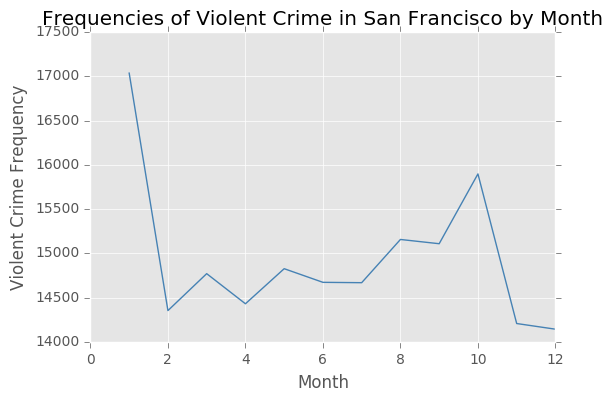

In [5]:
yearly_line = plt.plot(plotdf['month'], plotdf['count of violent crimes'], color = 'steelblue')
plt.xlabel('Month')
plt.ylabel('Violent Crime Frequency')
plt.title('Frequencies of Violent Crime in San Francisco by Month')
plt.show()

It seems that the claim is wrong. By far, the most violent crime appears in the month of January (the most) and October. The lowest violent crimes actually happen to be in the summer months (although February has the lowest)

<h2> Question #2: What is the best time (hours) to get food from a mobile food vendor in the San Francisco area on Mondays?</h2>

For this question, I do need to look at all of the data. I aim to select the latitude and longitude from the mobile_food_location table and the starting, hour, day and ending hour. I will ask to user in a function in input which day they are interested in, in this case - Monday. 

To solve this problem, I need to look at a specific hour and count how many food trucks there are. This is essentially an overlapping interval problem. My algorithm to solve this problem is as follows: I initialize an empty array of 0's of size 24 (because there are 24 hours). I iterate through each interval for each food truck; for every time a truck is present between the start and end hour, I increment the hour's count on the array.

Let's combine the tables and filter them first.

In [91]:
besttime = pd.read_sql('''
select mobile_food_schedule.DayOfWeek, mobile_food_schedule.StartHour, mobile_food_schedule.EndHour
from mobile_food_locations, mobile_food_schedule
on mobile_food_locations.locationid = mobile_food_schedule.locationid
 
''', db)

besttime

,DayOfWeek,StartHour,EndHour
0,Fr,10,11
1,Mo,10,11
2,Th,10,11
3,Tu,10,11
4,We,10,11
5,Fr,9,10
6,Fr,0,13
7,Mo,9,10
8,Mo,0,13
9,Th,9,10


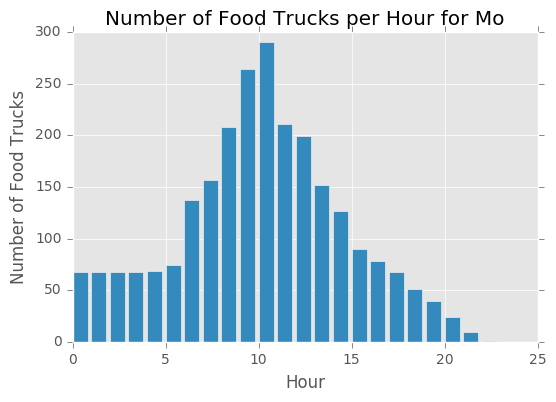

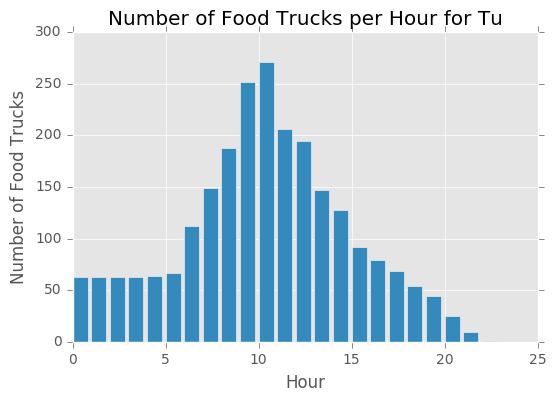

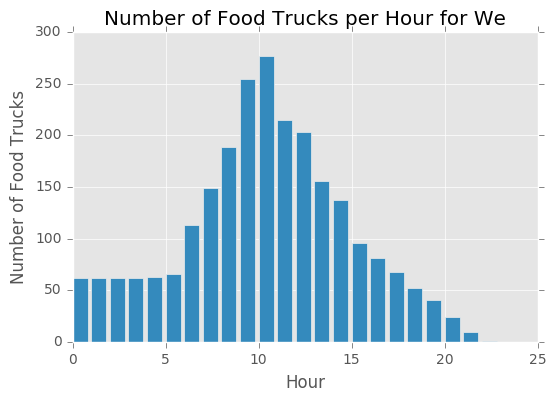

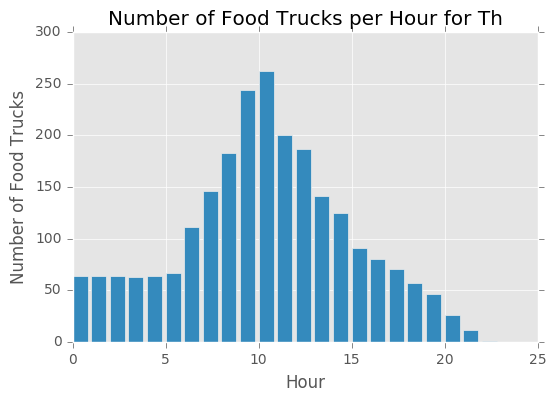

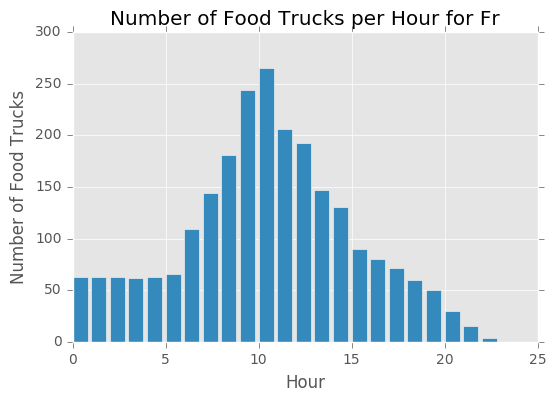

In [93]:
def best_range(day):
    '''
    Takes in specific location id and limits it to a region - 437191 returns
    data between locationids to the nearest 10000. In this case, 430000 and 440000.
    Plots start and ending hour on a bar chart
    
    input: string corresponding to day of week
    output: bar plot showing presense of food truck by hour
    '''
    bestloctime = besttime[(besttime.DayOfWeek == day)]
    food_truck_present = [0] * 24
    for s, e in zip(bestloctime.StartHour, bestloctime.EndHour):
        for i in xrange(s, e):
            food_truck_present[i] += 1
    
    x = range(24)
    plt.bar(x, food_truck_present)
    plt.xlabel("Hour")
    plt.ylabel("Number of Food Trucks")
    plt.title("Number of Food Trucks per Hour for " + day)
    plt.show()

best_range("Mo")
best_range("Tu")
best_range("We")
best_range("Th")
best_range("Fr")




The distribution seems very consistent for each day. It seems that for all days, food trucks are most likely present from 10 to 11 am. Virtually no food trucks are in San Francisco after 10:00 pm for any day. 

Mondays are the best time to find a food truck between 10 and 11 am.



<h2> Question #3: During what months does San Francisco have the greatest number of construction projects going on? </h2>

At first glance, this question seems extremely hard to answer because there is no data on construction projects for the entire area of San Francisco. However, you can indirectly answer this question by looking at the noise table - more specifcally, we know that San Francisco residents will complain about noise even if it is a legally sanctioned construction project.

We will look at the noise table and look at only the columns that that have the word "construction" in them. We shall do this filtering by SQL first before analyzing the data.

In [8]:
db.row_factory = sql.Row
con_month = db.execute('''
select strftime('%m', datetime), count(type) from noise where noise.Type like "construction%"
group by 1
order by 1 
''')
con_month = con_month.fetchall()

In [9]:
plotdf = DataFrame(con_month)
plotdf.columns = ['month', 'count of violent crimes']
plotdf

,month,count of violent crimes
0,01,98
1,02,99
2,03,53
3,04,60
4,05,75
5,06,82
6,07,45
7,08,92
8,09,173
9,10,174


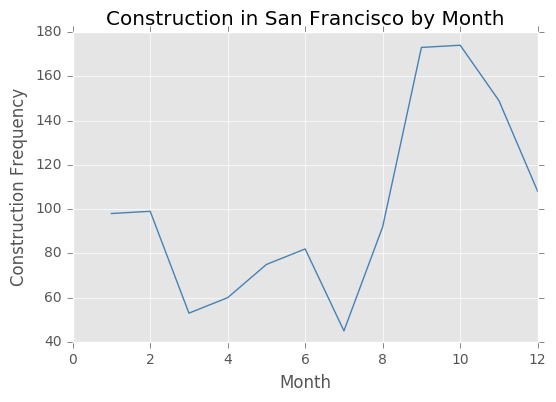

In [11]:
con_line = plt.plot(plotdf['month'], plotdf['count of violent crimes'], color = 'steelblue')
plt.xlabel('Month')
plt.ylabel('Construction Frequency')
plt.title('Construction in San Francisco by Month')
plt.show()

At first glance, we can conclude that construction rises around August and declines around the holiday season. It is the least in the summer months (it might be too hot for construction to occur). However, concluding this might be flawed because <b> we are not actually measuring the construction project rate by month; what we are actually measuring is the rate by which people complain about construction projects by month. </b>

So, we can conclude that people are least likely to complain about construction in the summer probably because summer is when people most likely go on vacation. We can conclude that September to October has the most noise complaints due to construction because the days get shorter and nights get earlier and people might need to rest and sleep sooner - hence, more noise complaints.

<h2> Question #4: Which areas in San Francisco are the most dangerous, in terms of robbery? </h2>

For this question, I'm looking at which areas are the most dangerous in San Francisco in terms of robbery? I first filter out the categories for robbery in SQL and use a process similar to what I did in the project to graph the incidents where a robbery has occured.

In [76]:
import matplotlib.cm

from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from matplotlib.colors import Normalize

In [130]:
assault = pd.read_sql("""
select crime.Category, crime.Lon, crime.Lat from crime where crime.Category like 'robbery%'

""", db)

assault


,Category,Lon,Lat
0,ROBBERY,-122.414406,37.784191
1,ROBBERY,-122.432198,37.765111
2,ROBBERY,-122.406832,37.796903
3,ROBBERY,-122.406832,37.796903
4,ROBBERY,-122.413609,37.784697
5,ROBBERY,-122.410135,37.784189
6,ROBBERY,-122.419672,37.765050
7,ROBBERY,-122.396517,37.737156
8,ROBBERY,-122.403919,37.787116
9,ROBBERY,-122.405109,37.708856


In [136]:
assault.dtypes

Category     object
Lon         float64
Lat         float64
dtype: object

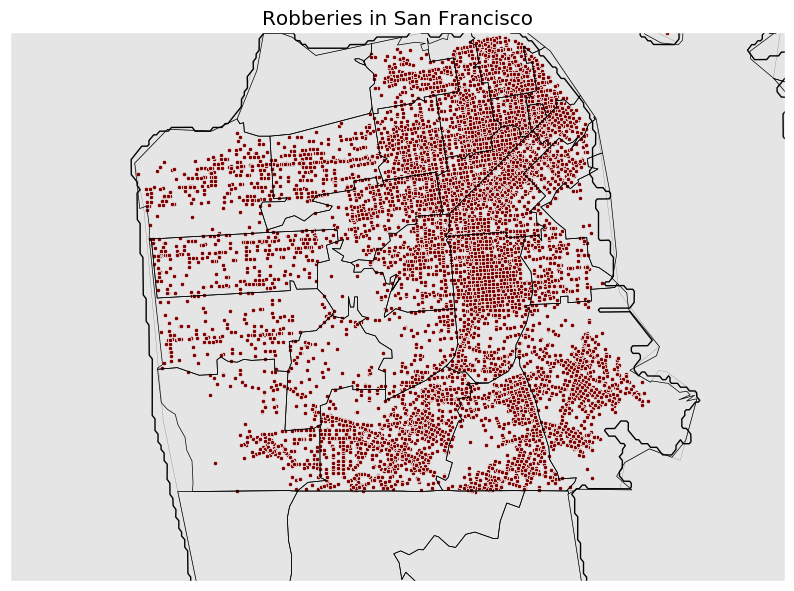

In [140]:
westlimit=-122.5494
southlimit=37.688303
eastlimit=-122.33242
northlimit=37.80992

fig, ax = plt.subplots(figsize=(10,20))
my_map = Basemap(llcrnrlon=westlimit, llcrnrlat=southlimit, 
                 urcrnrlon=eastlimit, urcrnrlat=northlimit, resolution="f",
    projection="merc"
)

my_map.drawcoastlines()
my_map.drawcounties()
my_map.readshapefile("./cb_2015_us_zcta510_500k1/cb_2015_us_zcta510_500k", "zipcodes")

x,y = my_map([longs for longs in assault.Lon],
         [lats for lats in assault.Lat])
plt.title("Robberies in San Francisco")
my_map.scatter(x,y, s = 10, c = "maroon")
my_map

It seems that the majority of robberies are concentrated on the Tenderloin/Financial District near northeast San Francisco. This is probably because the area houses the richest neighboorhoods in the District, which makes it exceptionally fortutious for theives to steal in the area. The Tenderloin is also one of San Francisco's most notorious neighborhood and according to one author on Vice, "as close as you can get to an open air drug market in one of America's wealtiest cities."

<h2> Question #5: Which regions of San Francisco have the highest median housing prices? Which have the lowest? </h2>

Instead of answering this question with a bar graph, I aim to use Basemap and matplotlib's libraries to build a choropleth or colormap. A choroplete is a thematic map in which areas are shaded or patterned in proportion to the measurement of the statistical variable being displayed on the map, such as population density or per-capita income. Thus, areas with higher values will have darker colors compared areas with smaller values. Here, the value is the median price per square feet that I scraped using SQL from the zillow table. 

In [171]:
housing = pd.read_sql('''select zillow.RegionName, zillow.MedianSoldPricePerSqft_AllHomes from zillow 
where zillow.MedianSoldPricePerSqft_AllHomes is not NULL''', db)

housing.columns = ['area', 'price']
housing.area = housing.area.astype(str)

housing

,area,price
0,94109,675.191300
1,94110,599.678500
2,94122,495.443200
3,94080,369.553800
4,94112,422.453800
5,94115,667.122500
6,94117,751.941400
7,94121,500.423900
8,94118,578.990300
9,94114,716.420200


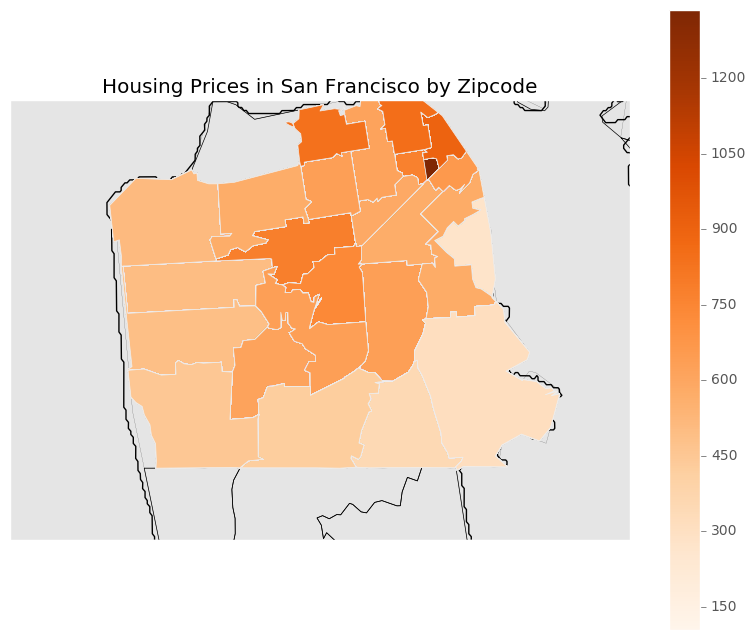

In [208]:
westlimit=-122.5494
southlimit=37.688303
eastlimit=-122.33242
northlimit=37.80992

fig, ax = plt.subplots(figsize=(10,20))
my_map = Basemap(llcrnrlon=westlimit, llcrnrlat=southlimit, 
                 urcrnrlon=eastlimit, urcrnrlat=northlimit, resolution="f",
    projection="merc"
)

my_map.drawcoastlines()
my_map.drawcounties()
my_map.readshapefile("./cb_2015_us_zcta510_500k1/cb_2015_us_zcta510_500k", "zipcodes")

df_poly = pd.DataFrame({
        'shapes': [Polygon(np.array(shape), True) for shape in my_map.zipcodes],
        'area': [area['ZCTA5CE10'] for area in my_map.zipcodes_info]
    })
df_poly = df_poly.merge(housing, on='area', how='right')
cmap = plt.get_cmap('Oranges')   
pc = PatchCollection(df_poly.shapes, zorder=2)
norm = Normalize()
 
pc.set_facecolor(cmap(norm(df_poly['price'].fillna(0).values)))
ax.add_collection(pc)

mapper = matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap)
 
mapper.set_array(df_poly['price'])
plt.title("Housing Prices in San Francisco by Zipcode")
plt.colorbar(mapper, shrink=0.4)

my_map

It seems that the majority of the most expensive houses (as measured by the median price pers square ft) are located in the top north-eastern area of San Francisco. This coincidentally also happens to be the area where the most robberies happen. The area with the highest median price is one with the zipcode 94104, which is the heart of the Financial District. The areas with the lowest median price 94124 area, Bayview, the southeastern corner of San Francisco. This is a small island of relatively medium to high expensive houses in Central San Francisco but it's nothing compared to the Financial/Tenderloin District. 